<a href="https://colab.research.google.com/github/jbenasuli/final_project/blob/main/dev/database/Amazon_Vine-PySpark-ETLs/Airmattress_ETL_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.0'
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-05-20 00:49:57--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2021-05-20 00:49:58 (6.59 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
import datetime
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col
from pyspark.sql.types import StructField, StringType, IntegerType, StructType, BooleanType, DateType
from pyspark import SparkFiles

In [5]:
# Create dataframe with raw data from 'outdoors' category
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Outdoors_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()
print((df.count(), len(df.columns)))

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   18446823|R35T75OLUGHL5C|B000NV6H94|     110804376|Stearns Youth Boa...|        Outdoors|          4|            0|          0|   N|                Y|          Four Stars|          GOOD VALUE| 2015-08-31|
|         US|   13724367|R2BV735O46BN33|B000IN0W3Y|     624096774|Primal Wear Men's...|        Outdoors|          5|    

In [6]:
# Filter the data and create a new DataFrame or table to retrieve all the rows for that specific product
airmattress_df = df.filter(df.product_id == "B000M0MJU2")
airmattress_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   46387114|R26RZ3C5VL3H5W|B000M0MJU2|     805416447|Intex Raised Down...|        Outdoors|          5|            0|          0|   N|                Y|          Five Stars|Very comfortable ...| 2015-08-31|
|         US|   44581842|R2A498KG3CWVC3|B000M0MJU2|     805416447|Intex Raised Down...|        Outdoors|          1|    

In [7]:
#2 Check the schema
airmattress_df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [8]:
#3 Drop the non-beneficial columns
columns_to_drop = ["marketplace"]
airmattress_df = airmattress_df.drop(*columns_to_drop)
airmattress_df.show()

+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|   46387114|R26RZ3C5VL3H5W|B000M0MJU2|     805416447|Intex Raised Down...|        Outdoors|          5|            0|          0|   N|                Y|          Five Stars|Very comfortable ...| 2015-08-31|
|   44581842|R2A498KG3CWVC3|B000M0MJU2|     805416447|Intex Raised Down...|        Outdoors|          1|            1|          1|   N|                N|    Cannot Reco

In [9]:
#4 Convert date from string to datetime
from pyspark.sql.types import *
airmattress_df = airmattress_df.withColumn("review_date", airmattress_df["review_date"].cast(DateType()))
airmattress_df.printSchema()
airmattress_df.show()

root
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)

+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_head

In [10]:
#5 star rating already IntegerType
# check row count before export write
final_row_count = airmattress_df.count()
print("{:,}".format(final_row_count))

4,753


# Start Text Clean

In [11]:
# 6 Convert Pyspark dataframe into panda df
df_airmattress = airmattress_df.toPandas()
df_airmattress

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,46387114,R26RZ3C5VL3H5W,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,0,0,N,Y,Five Stars,Very comfortable and easy to set up.,2015-08-31
1,44581842,R2A498KG3CWVC3,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,1,1,1,N,N,Cannot Recommend,This airmatress does not hold air. The first n...,2015-08-31
2,32473989,R33Z46RRJXS3O7,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,0,0,N,Y,Five Stars,Good product Great quality,2015-08-31
3,7668480,R1W6FG4HPA0K6C,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,0,0,N,Y,Five Stars,Super comfortable!!! I am 6 months pregnant an...,2015-08-31
4,2368997,R3JTF0SET2BV4Y,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,0,0,N,Y,Five Stars,good,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748,10221632,R2K0TL4VNH71AB,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,7,8,N,Y,Intex Raised Downy Queen Airbed with Built-in ...,Good buy. Very Little Leak. The bed itself is ...,2008-06-04
4749,52922779,R3FMSB7NVM64SP,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,4,4,N,Y,great traveling bed,this is a great thing to have. the built in pu...,2008-04-12
4750,45643821,R3JPX7JXE4JF61,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,5,19,20,N,N,Amazing! Like a real bed!,This air mattress is incredible. We bought it...,2008-04-08
4751,14464916,R2XZEVT9OE0BXI,B000M0MJU2,805416447,Intex Raised Downy Airbed with Built-in Electr...,Outdoors,4,6,7,N,Y,Good Bed,I have not had this item for very long and hav...,2008-03-26


In [12]:
# Import dependencies
import pandas as pd

#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [13]:
df_airmattress_saved = df_airmattress

In [14]:
# Drop columns not needed
df_product_clean = df_airmattress_saved.drop(columns=['product_id', 'product_parent', 'product_title', 'product_category', 
                                                      'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_date'])

In [15]:
# Clean the data reveiw_body

# Remove punctuation
df_product_clean['review_body'] = df_product_clean .review_body.str.replace("[^\w\s]", "")

# Make it all lower case
df_product_clean['review_body'] = df_product_clean.review_body.apply(lambda x: x.lower())

# Handle strange character in source
df_product_clean['review_body'] = df_product_clean.review_body.str.replace("‰Ûª", "''")

df_product_clean

,customer_id,review_id,star_rating,review_body
0,46387114,R26RZ3C5VL3H5W,5,very comfortable and easy to set up
1,44581842,R2A498KG3CWVC3,1,this airmatress does not hold air the first ni...
2,32473989,R33Z46RRJXS3O7,5,good product great quality
3,7668480,R1W6FG4HPA0K6C,5,super comfortable i am 6 months pregnant and s...
4,2368997,R3JTF0SET2BV4Y,5,good
...,...,...,...,...
4748,10221632,R2K0TL4VNH71AB,5,good buy very little leak the bed itself is ve...
4749,52922779,R3FMSB7NVM64SP,5,this is a great thing to have the built in pum...
4750,45643821,R3JPX7JXE4JF61,5,this air mattress is incredible we bought it ...
4751,14464916,R2XZEVT9OE0BXI,4,i have not had this item for very long and hav...


In [16]:
# Create a wordcloud
def WordCloudEng(data, stopwords, is_big = True):
    """Function to preprocess abstracts, including merging, deleting punctuation, stopwords, and lemmatization
       and return WordCloud object of the given data in English.
    
    Args:
        (DataFrame) data: the data that includes the abstracts.
        (set) stopwords: set of stopwords from NLTK library.
        (bool) is_big: Whether return a big word cloud or a small word cloud.

    Returns:
        (WordCloud): WordCloud object of the given data.
    """
    
    #MERGE ALL ABSTRACTS AND CREATE STOPWRODS DICTIONARY
    text = ''
    text = " ".join(abstract.lower() for abstract in data['review_body'])
    stopwords = stopwords.union(set(STOPWORDS))
    
    #LEMMATIZATION
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text) #Tokenizing
    tokens = [token for token in tokens if token.isalnum() and token not in stopwords] #Delete punctuation and stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #Using lemmatizer from NLTK library
    text = ' '.join([token for token in tokens]) #Put words back in text
    
    #CREATE WORD CLOUD
    if is_big:
        return WordCloud(width = 800, height = 800, max_words = 70, collocations = False).generate(text)
    else:
        return WordCloud(width = 800, height = 800, max_words = 25, collocations = False).generate(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


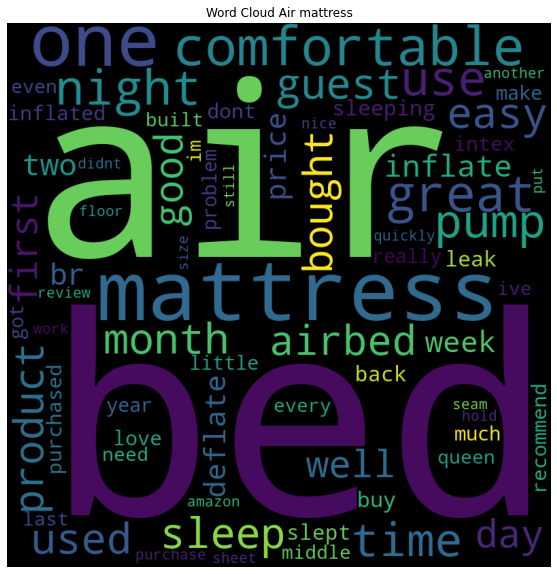

In [17]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import matplotlib.pyplot as plt

# Create word cloud
wordcloud = WordCloudEng(df_product_clean, set(stopwords.words('english')))
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title('Word Cloud Air mattress')
plt.axis("off")
plt.show()

### Connect to the AWS RDS instance and write each DataFrame to its table. 

In [18]:
sparkDF=spark.createDataFrame(df_product_clean) 

In [21]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://<connection_string>"
config = {"user":"<username>", 
          "password": "<password>", 
          "driver":"org.postgresql.Driver"}

In [22]:
# Write airmattress reviews to table in RDS
# 0.5 mins
sparkDF.write.jdbc(url=jdbc_url, table='airmattress_cleaned_v2', mode=mode, properties=config)